In [1]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Resnet_with_uncertainty, MLP_with_uncertainty#
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error # 
from tensorflow.keras.utils import to_categorical
import pandas as pd
from dependency import *
%matplotlib notebook

In [2]:
from model import Resnet_with_uncertainty,ResNet50_uncertainty,MLP_with_uncertainty
from second_stage_fusion_utils_concat2 import predict,predict3
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib notebook

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:04<00:00, 82.93it/s]


In [3]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc,average_precision_score,precision_recall_curve
import cv2
from dependency import *
import pandas as pd
from utils import encode_test_label,Logger,encode_meta_choosed_label,encode_meta_label
from tqdm import tqdm_notebook  

test_index_df = pd.read_csv(test_index_path)
train_index_df = pd.read_csv(train_index_path)
val_index_df = pd.read_csv(val_index_path)

train_index_list = list(train_index_df['indexes'])
val_index_list = list(val_index_df['indexes'])
test_index_list = list(test_index_df['indexes'])

train_index_list_1 = train_index_list[0:206]
train_index_list_2 = train_index_list[206:]

df = pd.read_csv(img_info_path)

In [4]:
def get_label_list(image_index_list):
    diag_label_list = []
    pn_label_list = []
    str_label_list = []
    pig_label_list = []
    rs_label_list = []
    dag_label_list = []
    bwv_label_list = []
    vs_label_list = []
    meta_list = []
    meta_list_one_hot = []
    
    img_feature = []
    img_hf_feature = []
    img_vf_feature = []
    img_vhf_feature = []

    from sklearn.decomposition import PCA

    from tqdm import tqdm_notebook,tqdm
    for index_num in tqdm(image_index_list):
    #index_num = test_index_list[100]
        img_info = df[index_num:index_num+1]
        clinic_path = img_info['clinic']
        dermoscopy_path = img_info['derm']
        source_dir = '../release_v0/release_v0/images/'
        clinic_img = cv2.imread(source_dir+clinic_path[index_num])
        dermoscopy_img = cv2.imread(source_dir+dermoscopy_path[index_num])
        '''select metadata: change here'''
        meta_vector_one_hot,meta_vector = encode_meta_choosed_label(img_info,index_num)
        
        [diagnosis_label,pigment_network_label,streaks_label,pigmentation_label,regression_structures_label,
         dots_and_globules_label,blue_whitish_veil_label, vascular_structures_label],[diagnosis_label_one_hot,pigment_network_label_one_hot,
        streaks_label_one_hot,pigmentation_label_one_hot,regression_structures_label_one_hot,
        dots_and_globules_label_one_hot,blue_whitish_veil_label_one_hot, vascular_structures_label_one_hot] = encode_test_label(img_info,index_num)

        diag_label_list.append(diagnosis_label)
        pn_label_list.append(pigment_network_label)
        str_label_list.append(streaks_label)
        pig_label_list.append(pigmentation_label)
        rs_label_list.append(regression_structures_label)
        dag_label_list.append(dots_and_globules_label)
        bwv_label_list.append(blue_whitish_veil_label)
        vs_label_list.append(vascular_structures_label)
        meta_list.append(meta_vector)
        meta_list_one_hot.append(meta_vector_one_hot)



    label_dict ={'diag':diag_label_list,
                 'pn':pn_label_list,
                 'str':str_label_list,
                 'pig':pig_label_list,
                 'rs':rs_label_list,
                 'dag':dag_label_list,
                 'bwv':bwv_label_list,
                 'vs':vs_label_list}
    
    return label_dict,meta_list,meta_list_one_hot

# multi-modality with uncertainty(derm, clinic, and metadata) fusion here

./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/2/checkpoint/best_mean_acc_model.pth
./multimodal_MLP_Normal_weight_file/2/checkpoint/best_mean_acc_model.pth
P1--------------------------------on images

--- [START IDENTIFIER] ----------------------------------------------------------------




100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [01:01<00:00,  6.44it/s]


---------------

avg_acc : 0.75

vs_acc : 0.8278481012658228

bwv_acc : 0.8734177215189873

dag_acc : 0.6025316455696202

rs_acc : 0.8050632911392405

pig_acc : 0.7265822784810126

str_acc : 0.7518987341772152

pn_acc : 0.7063291139240506

diag_acc : 0.7063291139240506

Diag-------------------------

nevu_SEN: 0.9269406392694064, SPE: 0.6363636363636364, PRE: 0.7602996254681648
bcc SEN: 0.25, SPE: 0.9736147757255936, PRE: 0.2857142857142857
mel SEN: 0.5643564356435643, SPE: 0.8979591836734694, PRE: 0.6551724137931034
misc SEN: 0.375, SPE: 0.971830985915493, PRE: 0.6
sk SEN: 0.0, SPE: 0.9946808510638298, PRE: 0.0
----------

pn_asb SEN: 0.6666666666666666, SPE: 0.9163179916317992, PRE: 0.8387096774193549
pn_typ SEN: 0.8287671232876712, SPE: 0.7429718875502008, PRE: 0.654054054054054
pn_aty SEN: 0.5806451612903226, SPE: 0.8940397350993378, PRE: 0.627906976744186
----------

str_asb SEN: 0.8715953307392996, SPE: 0.6811594202898551, PRE: 0.835820895522388
str_reg SEN: 0.4772727272727273, S

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [01:14<00:00,  5.30it/s]
E:\university\my_project\metadata_analysis\fusion model\uncertainty model\second_stage_fusion_utils_concat2.py:1240: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)


---------------

avg_acc : 0.769620253164557

vs_acc : 0.810126582278481

bwv_acc : 0.8734177215189873

dag_acc : 0.6860759493670886

rs_acc : 0.8050632911392405

pig_acc : 0.7240506329113924

str_acc : 0.739240506329114

pn_acc : 0.7341772151898734

diag_acc : 0.7848101265822784

Diag-------------------------

nevu_SEN: 0.958904109589041, SPE: 0.6590909090909091, PRE: 0.7777777777777778
bcc SEN: 0.625, SPE: 0.9894459102902374, PRE: 0.7142857142857143
mel SEN: 0.693069306930693, SPE: 0.9387755102040817, PRE: 0.7954545454545454
misc SEN: 0.4, SPE: 0.9915492957746479, PRE: 0.8421052631578947
sk SEN: 0.21052631578947367, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.7051282051282052, SPE: 0.9037656903765691, PRE: 0.8270676691729323
pn_typ SEN: 0.8424657534246576, SPE: 0.7751004016064257, PRE: 0.6871508379888268
pn_aty SEN: 0.6129032258064516, SPE: 0.9139072847682119, PRE: 0.6867469879518072
----------

str_asb SEN: 0.9455252918287937, SPE: 0.43478260869565216, PRE: 0.7570093457943925
str_r

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [01:21<00:00,  4.83it/s]


<IPython.core.display.Javascript object>


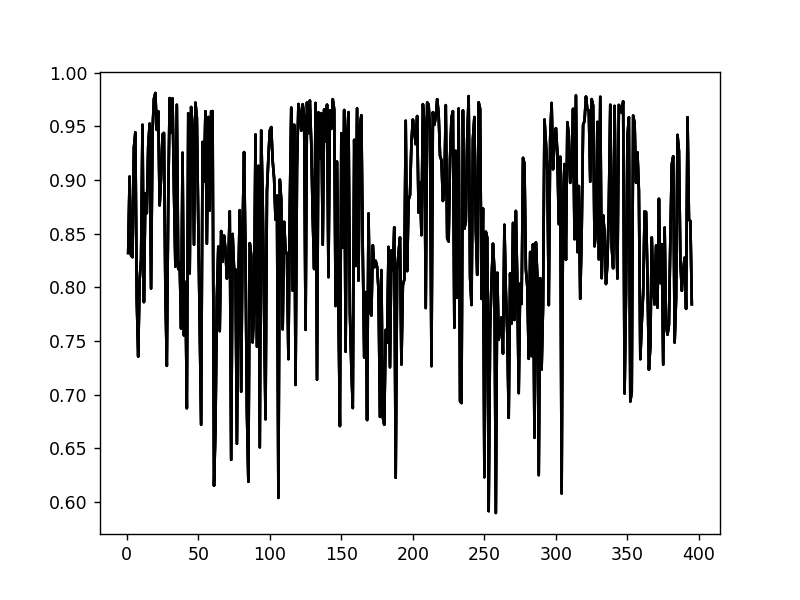

E:\university\my_project\metadata_analysis\fusion model\uncertainty model\second_stage_fusion_utils_concat2.py:2592: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)


---------------

avg_acc : 0.7683544303797469

vs_acc : 0.8227848101265823

bwv_acc : 0.8708860759493671

dag_acc : 0.6582278481012658

rs_acc : 0.8151898734177215

pig_acc : 0.7316455696202532

str_acc : 0.7772151898734178

pn_acc : 0.7164556962025317

diag_acc : 0.7544303797468355

Diag-------------------------

nevu_SEN: 0.9497716894977168, SPE: 0.6363636363636364, PRE: 0.7647058823529411
bcc SEN: 0.625, SPE: 0.9841688654353562, PRE: 0.625
mel SEN: 0.6237623762376238, SPE: 0.9183673469387755, PRE: 0.7241379310344828
misc SEN: 0.35, SPE: 0.9915492957746479, PRE: 0.8235294117647058
sk SEN: 0.15789473684210525, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.6923076923076923, SPE: 0.9079497907949791, PRE: 0.8307692307692308
pn_typ SEN: 0.8493150684931506, SPE: 0.7469879518072289, PRE: 0.6631016042780749
pn_aty SEN: 0.5483870967741935, SPE: 0.9105960264900662, PRE: 0.6538461538461539
----------

str_asb SEN: 0.953307392996109, SPE: 0.5362318840579711, PRE: 0.7928802588996764
str_reg SEN: 0

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [01:35<00:00,  4.15it/s]
E:\university\my_project\metadata_analysis\fusion model\uncertainty model\second_stage_fusion_utils_concat2.py:2592: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)


---------------

avg_acc : 0.7683544303797468

vs_acc : 0.8164556962025317

bwv_acc : 0.8721518987341772

dag_acc : 0.6721518987341772

rs_acc : 0.8088607594936709

pig_acc : 0.7240506329113924

str_acc : 0.7632911392405063

pn_acc : 0.7240506329113924

diag_acc : 0.7658227848101266

Diag-------------------------

nevu_SEN: 0.952054794520548, SPE: 0.6448863636363636, PRE: 0.7693726937269373
bcc SEN: 0.625, SPE: 0.9854881266490765, PRE: 0.6451612903225806
mel SEN: 0.6485148514851485, SPE: 0.9268707482993197, PRE: 0.7528735632183908
misc SEN: 0.375, SPE: 0.9915492957746479, PRE: 0.8333333333333334
sk SEN: 0.18421052631578946, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.7019230769230769, SPE: 0.9058577405857741, PRE: 0.8295454545454546
pn_typ SEN: 0.8493150684931506, SPE: 0.7570281124497992, PRE: 0.6720867208672087
pn_aty SEN: 0.5645161290322581, SPE: 0.9139072847682119, PRE: 0.6687898089171974
----------

str_asb SEN: 0.9552529182879378, SPE: 0.4855072463768116, PRE: 0.7756714060031595


100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [01:39<00:00,  3.96it/s]
E:\university\my_project\metadata_analysis\fusion model\uncertainty model\second_stage_fusion_utils_concat2.py:2592: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)


---------------

avg_acc : 0.7690928270042195

vs_acc : 0.8151898734177215

bwv_acc : 0.8717299578059071

dag_acc : 0.6776371308016877

rs_acc : 0.8084388185654009

pig_acc : 0.7265822784810126

str_acc : 0.760337552742616

pn_acc : 0.7240506329113924

diag_acc : 0.7687763713080169

Diag-------------------------

nevu_SEN: 0.9528158295281582, SPE: 0.6477272727272727, PRE: 0.770935960591133
bcc SEN: 0.625, SPE: 0.9868073878627969, PRE: 0.6666666666666666
mel SEN: 0.6534653465346535, SPE: 0.927437641723356, PRE: 0.7557251908396947
misc SEN: 0.38333333333333336, SPE: 0.9915492957746479, PRE: 0.8363636363636363
sk SEN: 0.19298245614035087, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.7029914529914529, SPE: 0.9037656903765691, PRE: 0.8266331658291457
pn_typ SEN: 0.8515981735159818, SPE: 0.7563587684069611, PRE: 0.6720720720720721
pn_aty SEN: 0.5591397849462365, SPE: 0.9161147902869757, PRE: 0.6724137931034483
----------

str_asb SEN: 0.9546044098573282, SPE: 0.4782608695652174, PRE: 0.77310

In [5]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
seed = 0
mode = 'multimodal(copy2)'
model_name = 'Resnet_cos-loss and concat'
import random
random.seed(seed)
TTA = 6
img_type="concat"
size = 229
data_mode = 'Normal'

#change i here!
i = 2

p1_acc_list = []
p2_acc_list = []
p3_acc_list = []

mean_avg_acc_list = []

weight_file = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format(mode,model_name,data_mode,i)
print(weight_file)

net = Resnet_with_uncertainty(class_list).cuda()
net.load_state_dict(torch.load(weight_file))

weight_file2 = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format("multimodal","MLP",data_mode,i)
print(weight_file2)

net2 =  MLP_with_uncertainty(class_list).cuda()

net2.load_state_dict(torch.load(weight_file2))
print("P1--------------------------------on images")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P1")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"img")
print("P2--------------------------------on metadata")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P2")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"metadata")
prob_2 = prob
pn_prob_2 = pn_prob
str_prob_2 = str_prob
pig_prob_2 = pig_prob
rs_prob_2 = rs_prob
dag_prob_2 = dag_prob
bwv_prob_2 = bwv_prob
vs_prob_2 = vs_prob
uncertainty_2 = uncertainty_pred
p2_list  = [prob_2,pn_prob_2,str_prob_2,pig_prob_2,rs_prob_2,dag_prob_2,bwv_prob_2,vs_prob_2,uncertainty_2]
print("P2 Done")

print("(clinic, derm)-concat & metadata fusion here!------------------------------------------------")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P3")
(avg_acc,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict3(net,net2,test_index_list,df,model_name,out_dir,mode,TTA,size,img_type)
